In [1]:
# Test imports
import numpy as np
print(f"NumPy version: {np.__version__}")

import torch
print(f"PyTorch version: {torch.__version__}")

import pytorch3d
print(f"PyTorch3D version: {pytorch3d.__version__}")

import matplotlib.pyplot as plt
print("Matplotlib imported successfully!")

from starter.utils import get_device, get_mesh_renderer, load_cow_mesh
print("All imports successful!")

NumPy version: 1.26.4
PyTorch version: 2.5.1+cu121
PyTorch3D version: 0.7.8
Matplotlib imported successfully!
All imports successful!


# 0.1 Rendering your first mesh

Using device: cuda:0
Vertices shape: torch.Size([2930, 3])
Faces shape: torch.Size([5856, 3])


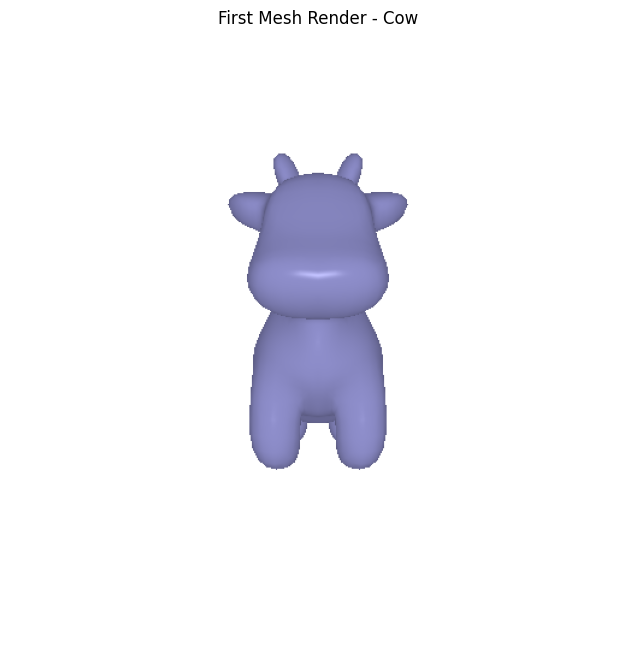

Rendering complete! The cow mesh has been successfully rendered.


In [ ]:
# Set up device
device = get_device()
print(f"Using device: {device}")

# Get the renderer
renderer = get_mesh_renderer(image_size=512, device=device)

# Load the cow mesh
vertices, faces = load_cow_mesh("data/cow.obj")
print(f"Vertices shape: {vertices.shape}")
print(f"Faces shape: {faces.shape}")

# Prepare mesh data (PyTorch3D requires batched tensors)
vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)

# Create texture (single color for all vertices)
textures = torch.ones_like(vertices)  # (1, N_v, 3)
textures = textures * torch.tensor([0.7, 0.7, 1]) # Blue

# Create the mesh
mesh = pytorch3d.structures.Meshes(
    verts=vertices,
    faces=faces,
    textures=pytorch3d.renderer.TexturesVertex(textures),
)
mesh = mesh.to(device)

# Set up camera (looking at origin from distance 3)
cameras = pytorch3d.renderer.FoVPerspectiveCameras(
    R=torch.eye(3).unsqueeze(0),  # Identity rotation
    T=torch.tensor([[0, 0, 3]]),  # Translation: 3 units back
    fov=60,  # Field of view in degrees
    device=device
)

# Set up lighting
lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)

# Render the mesh
rend = renderer(mesh, cameras=cameras, lights=lights)
image = rend.cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)

# Display the result
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.title('First Mesh Render - Cow')
plt.show()

print("Rendering complete! The cow mesh has been successfully rendered.")

# 1. Practicing with Cameras (15 Points)

100%|██████████| 72/72 [00:00<00:00, 89.49it/s] 


360-degree gif saved as outputs/cow_360.gif


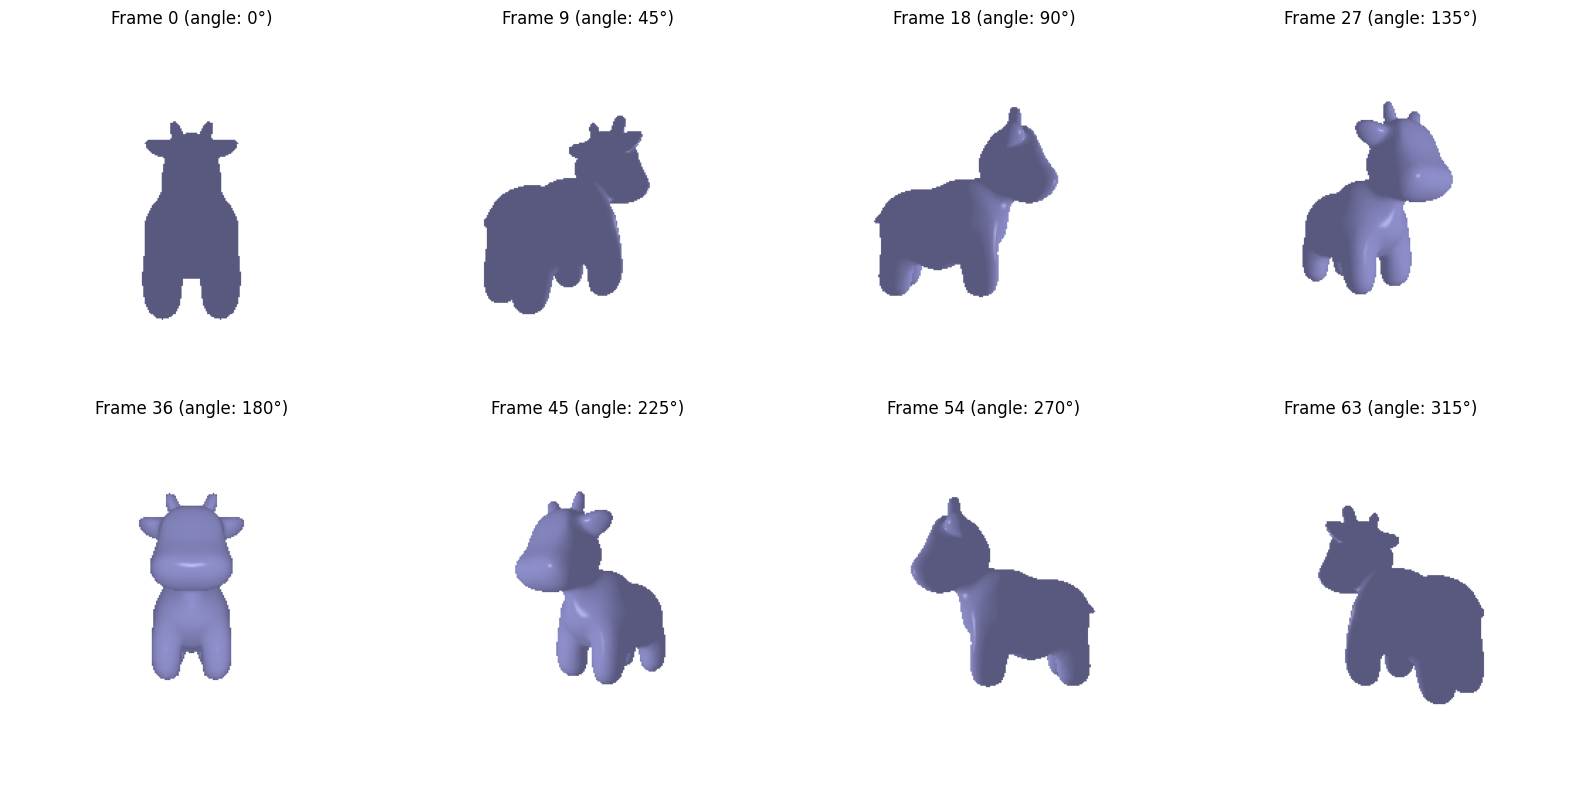

In [ ]:
# 1.1 360-degree Renders
import os
import torch
import pytorch3d
import imageio
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from starter.utils import get_device, get_mesh_renderer, load_cow_mesh

os.makedirs("outputs", exist_ok=True)

def render_360_degree_cow(image_size=256, num_views=72, output_file="outputs/cow_360.gif"):
    """
    Create a 360-degree gif of the cow mesh
    """
    device = get_device()
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    
    # Load and prepare mesh
    vertices, faces = load_cow_mesh("data/cow.obj")
    vertices = vertices.unsqueeze(0)
    faces = faces.unsqueeze(0)
    textures = torch.ones_like(vertices) * torch.tensor([0.7, 0.7, 1])
    
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)
    
    # Set up lighting
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
    
    # Generate views around the cow
    renders = []
    for angle in tqdm(range(0, 360, 360 // num_views)):
        # Create camera at different azimuth angles
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=3,      # Distance from origin
            elev=0,      # Elevation angle (0 = horizontal)
            azim=angle   # Azimuth angle (rotation around Y-axis)
        )
        
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        # Render
        rend = renderer(mesh, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]
        
        # Convert to uint8 for gif
        rend = (rend * 255).astype(np.uint8)
        renders.append(rend)
    
    # Save as gif
    # For 15 fps: duration = 1000/15 ≈ 67ms per frame
    duration = 1000 // 15  # 67ms per frame
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"360-degree gif saved as {output_file}")
    
    return renders

# Create the 360-degree gif
renders = render_360_degree_cow(image_size=256, num_views=72, output_file="outputs/cow_360.gif")

# Display a few frames
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i in range(8):
    frame_idx = i * 9  # Show every 9th frame
    axes[i].imshow(renders[frame_idx])
    axes[i].set_title(f'Frame {frame_idx} (angle: {frame_idx * 5}°)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 30/30 [00:00<00:00, 79.25it/s]


Dolly zoom gif saved as outputs/dolly_zoom.gif


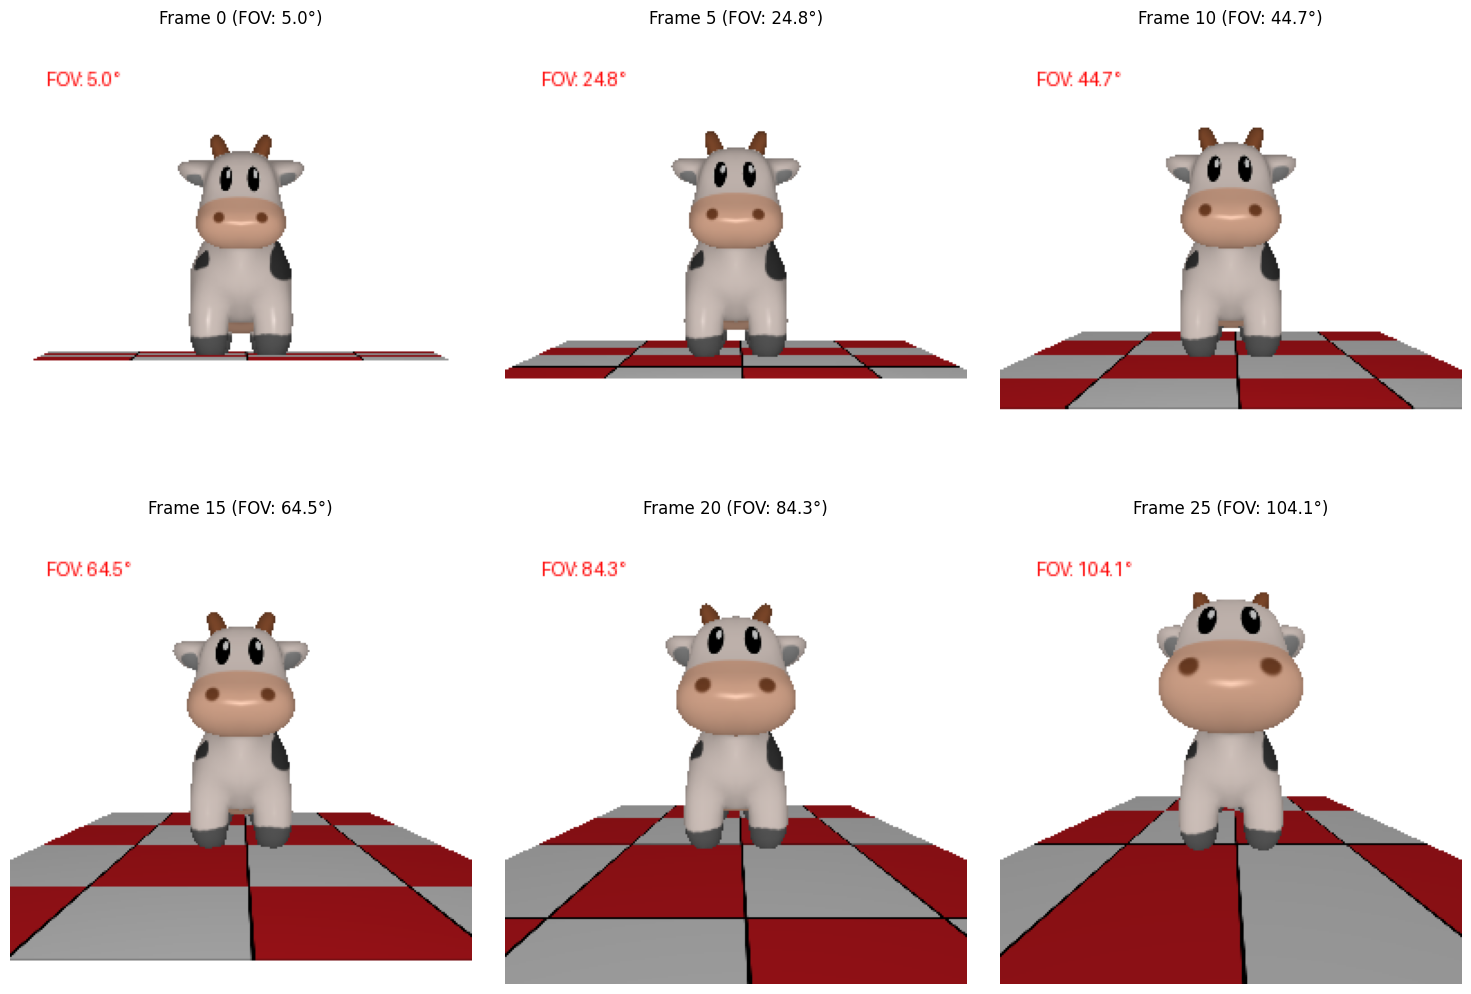

Dolly zoom effect complete!
The effect maintains the cow's apparent size while changing the field of view,
creating the characteristic 'vertigo' effect where the background appears to change perspective.


In [ ]:
# 1.2 Re-creating the Dolly Zoom 
import imageio
import numpy as np
from PIL import Image, ImageDraw
from tqdm.auto import tqdm
import os

def dolly_zoom_effect(image_size=256, num_frames=30, duration=3, output_file="outputs/dolly_zoom.gif"):
    """
    Create a dolly zoom effect by changing FOV while maintaining subject size
    """
    device = get_device()
    
    # Load the cow on plane mesh
    mesh = pytorch3d.io.load_objs_as_meshes(["data/cow_on_plane.obj"])
    mesh = mesh.to(device)
    
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    lights = pytorch3d.renderer.PointLights(location=[[0.0, 0.0, -3.0]], device=device)
    
    # Create FOV range (from wide to narrow)
    fovs = torch.linspace(5, 120, num_frames)
    
    renders = []
    for fov in tqdm(fovs):
        # Calculate distance to maintain subject size
        # For dolly zoom: distance = object_width / (2 * tan(fov/2)) -> Object is projected to be the same size on the image plane
        # We use a reference distance of 3 at FOV 60
        reference_fov = 60
        reference_distance = 3
        object_width = reference_distance * 2 * np.tan(np.radians(reference_fov / 2))
        distance = object_width / (2 * np.tan(np.radians(fov / 2)))
        
        # Set camera position
        T = [[0, 0, distance]]
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(fov=fov, T=T, device=device)
        
        rend = renderer(mesh, cameras=cameras, lights=lights)
        rend = rend[0, ..., :3].cpu().numpy()
        renders.append(rend)
    
    # Add FOV text to each frame
    images = []
    for i, r in enumerate(renders):
        image = Image.fromarray((r * 255).astype(np.uint8))
        draw = ImageDraw.Draw(image)
        draw.text((20, 20), f"FOV: {fovs[i]:.1f}°", fill=(255, 0, 0))
        images.append(np.array(image))
    
    # Save as gif
    # duration is in milliseconds per frame
    duration_ms = (duration * 1000) // num_frames  # Total duration in ms / number of frames
    imageio.mimsave(output_file, images, duration=duration_ms, loop=0)
    print(f"Dolly zoom gif saved as {output_file}")
    
    return images

# Create the dolly zoom effect
dolly_images = dolly_zoom_effect(
    image_size=256, 
    num_frames=30, 
    duration=3, 
    output_file="outputs/dolly_zoom.gif"
)

# Display key frames
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()
key_frames = [0, 5, 10, 15, 20, 25]  # Show 6 key frames
for i, frame_idx in enumerate(key_frames):
    axes[i].imshow(dolly_images[frame_idx])
    fov = 5 + (120 - 5) * frame_idx / 29  # Calculate FOV for this frame
    axes[i].set_title(f'Frame {frame_idx} (FOV: {fov:.1f}°)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

print("Dolly zoom effect complete!")
print("The effect maintains the cow's apparent size while changing the field of view,")
print("creating the characteristic 'vertigo' effect where the background appears to change perspective.")

# 2. Practicing with Meshes (10 Points)

100%|██████████| 72/72 [00:00<00:00, 84.18it/s] 


Tetrahedron 360-degree gif saved as outputs/tetrahedron_360.gif


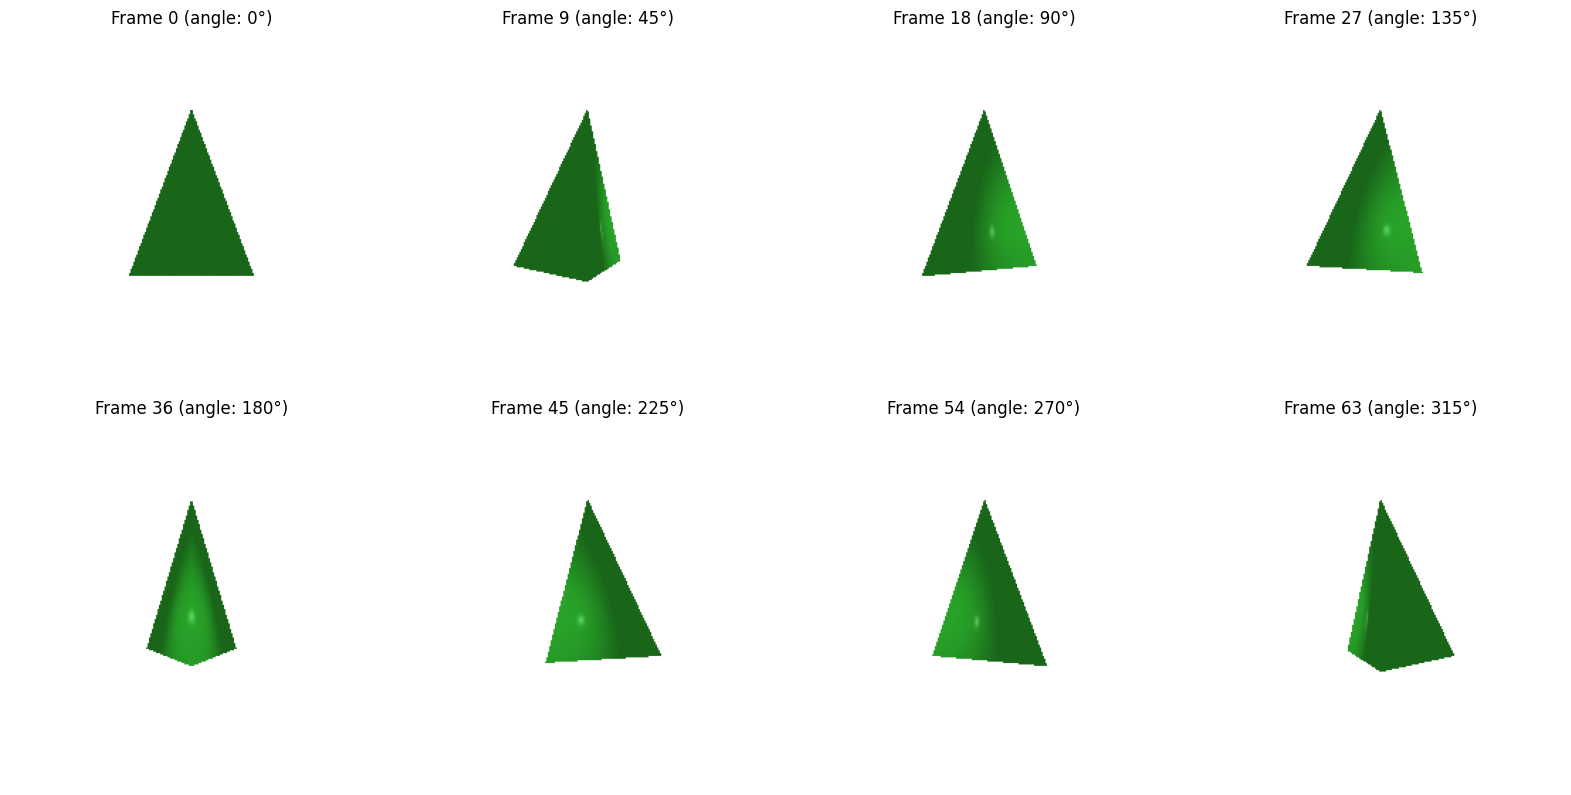

In [38]:
# 2.1 Constructing a Tetrahedron
import torch
import pytorch3d
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from starter.utils import get_device, get_mesh_renderer

def create_tetrahedron_mesh():
    """
    Create a tetrahedron mesh with 4 vertices and 4 triangular faces
    """
    # Define vertices of a tetrahedron
    # 4 vertices forming 4 triangular faces
    vertices = torch.tensor([
        [0.0, 1.0, 0.0],    # Vertex 0: Top
        [-0.5, -0.5, 0.5],  # Vertex 1: Bottom front left
        [0.5, -0.5, 0.5],   # Vertex 2: Bottom front right
        [0.0, -0.5, -0.5]   # Vertex 3: Bottom back
    ], dtype=torch.float32)
    
    # Define faces (triangular faces using vertex indices)
    # Each face is defined by 3 vertices in counter-clockwise order
    faces = torch.tensor([
        [0, 1, 2],  # Top face: vertices 0, 1, 2
        [0, 2, 3],  # Right face: vertices 0, 2, 3
        [0, 3, 1],  # Left face: vertices 0, 3, 1
        [1, 3, 2]   # Bottom face: vertices 1, 3, 2
    ], dtype=torch.long)
    
    
    return vertices, faces

def render_tetrahedron_360(image_size=256, num_views=72, output_file="outputs/tetrahedron_360.gif"):
    """
    Create a 360-degree gif of the tetrahedron
    """
    device = get_device()
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    
    # Create tetrahedron mesh
    vertices, faces = create_tetrahedron_mesh()
    
    # Prepare mesh data (PyTorch3D requires batched tensors)
    vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    
    # Create texture (single color for all vertices)
    textures = torch.ones_like(vertices) * torch.tensor([0.2, 0.8, 0.2])  # Green color
    
    # Create the mesh
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)
    
    # Set up lighting
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
    
    # Generate views around the tetrahedron
    renders = []
    for angle in tqdm(range(0, 360, 360 // num_views)):
        # Create camera at different azimuth angles
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=3,      # Distance from origin
            elev=0,      # Elevation angle (0 = horizontal)
            azim=angle   # Azimuth angle (rotation around Y-axis)
        )
        
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        # Render
        rend = renderer(mesh, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]
        
        # Convert to uint8 for gif
        rend = (rend * 255).astype(np.uint8)
        renders.append(rend)
    
    # Save as gif
    duration = 1000 // 15  # 67ms per frame for 15 fps
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Tetrahedron 360-degree gif saved as {output_file}")
    
    return renders

# Create and render the tetrahedron
tetrahedron_renders = render_tetrahedron_360(
    image_size=256, 
    num_views=72, 
    output_file="outputs/tetrahedron_360.gif"
)

# Display a few frames
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i in range(8):
    frame_idx = i * 9  # Show every 9th frame
    axes[i].imshow(tetrahedron_renders[frame_idx])
    axes[i].set_title(f'Frame {frame_idx} (angle: {frame_idx * 5}°)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 72/72 [00:00<00:00, 77.94it/s] 


Cube 360-degree gif saved as outputs/cube_360.gif


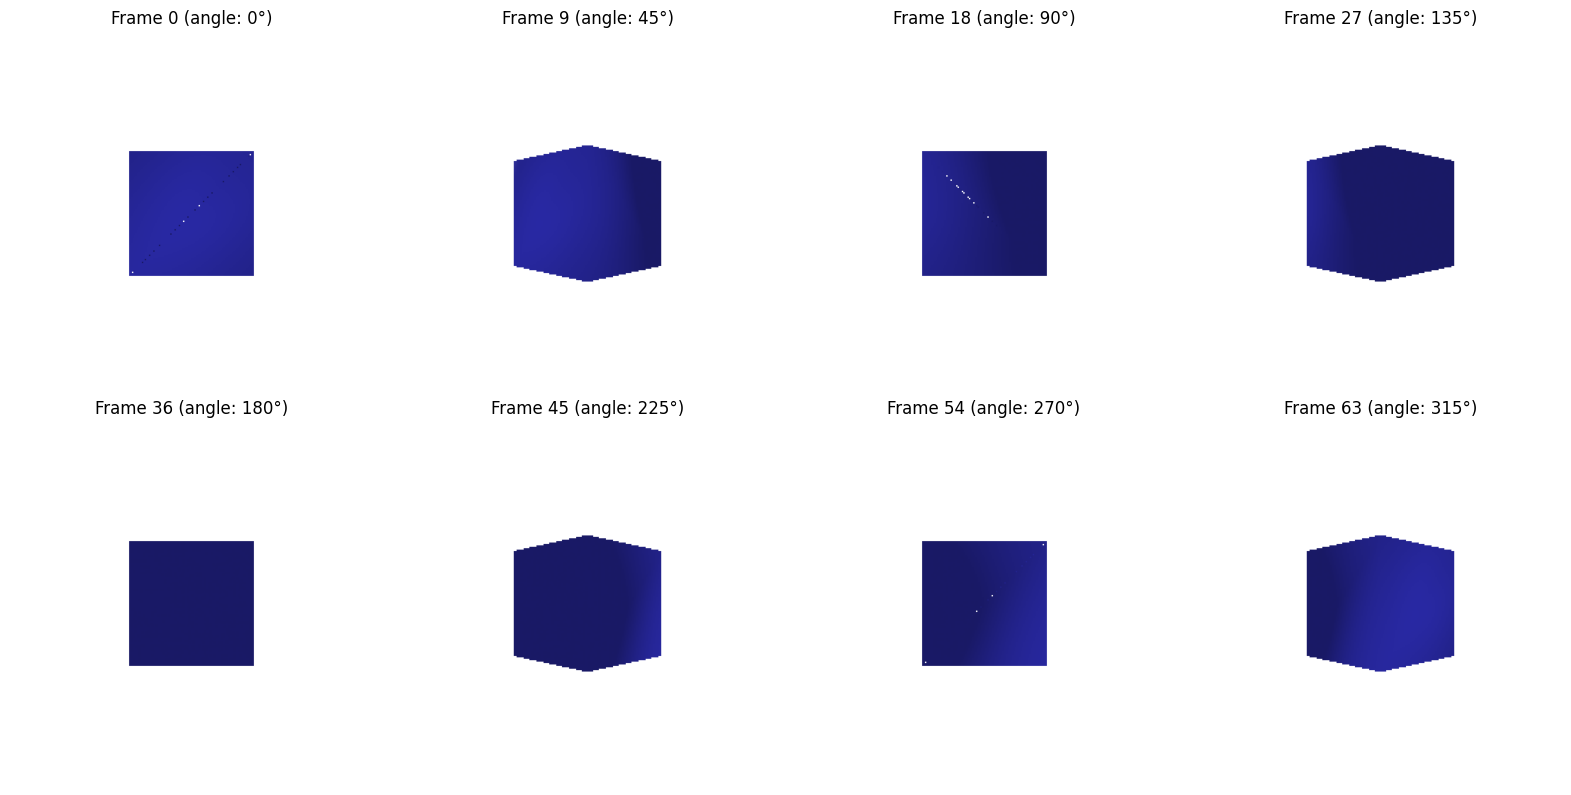

In [39]:
# 2.2 Constructing a Cube
import torch
import pytorch3d
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from starter.utils import get_device, get_mesh_renderer

def create_cube_mesh():
    """
    Create a cube mesh with 8 vertices and 12 triangular faces
    Each face of the cube is made of 2 triangles
    """
    # Define vertices of a cube (centered at origin)
    # A cube has 8 vertices
    vertices = torch.tensor([
        # Bottom face (z = -0.5)
        [-0.5, -0.5, -0.5],  # Vertex 0: Bottom back left
        [0.5, -0.5, -0.5],   # Vertex 1: Bottom back right
        [0.5, 0.5, -0.5],    # Vertex 2: Bottom front right
        [-0.5, 0.5, -0.5],   # Vertex 3: Bottom front left
        
        # Top face (z = 0.5)
        [-0.5, -0.5, 0.5],   # Vertex 4: Top back left
        [0.5, -0.5, 0.5],    # Vertex 5: Top back right
        [0.5, 0.5, 0.5],     # Vertex 6: Top front right
        [-0.5, 0.5, 0.5]     # Vertex 7: Top front left
    ], dtype=torch.float32)
    
    # Define faces (each face of the cube is made of 2 triangles)
    faces = torch.tensor([
        # Bottom face (z = -0.5) - 2 triangles
        [0, 1, 2], [0, 2, 3],
        
        # Top face (z = 0.5) - 2 triangles
        [4, 6, 5], [4, 7, 6],
        
        # Front face (y = 0.5) - 2 triangles
        [3, 2, 6], [3, 6, 7],
        
        # Back face (y = -0.5) - 2 triangles
        [0, 4, 5], [0, 5, 1],
        
        # Right face (x = 0.5) - 2 triangles
        [1, 5, 6], [1, 6, 2],
        
        # Left face (x = -0.5) - 2 triangles
        [0, 3, 7], [0, 7, 4]
    ], dtype=torch.long)

    
    return vertices, faces

def render_cube_360(image_size=256, num_views=72, output_file="outputs/cube_360.gif"):
    """
    Create a 360-degree gif of the cube
    """
    device = get_device()
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    
    # Create cube mesh
    vertices, faces = create_cube_mesh()
    
    vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    
    # Create texture (single color for all vertices)
    textures = torch.ones_like(vertices) * torch.tensor([0.2, 0.2, 0.8])  # Blue color
    
    # Create the mesh
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)
    
    # Set up lighting
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
    
    # Generate views around the cube
    renders = []
    for angle in tqdm(range(0, 360, 360 // num_views)):
        # Create camera at different azimuth angles
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=3,      # Distance from origin
            elev=0,      # Elevation angle (0 = horizontal)
            azim=angle   # Azimuth angle (rotation around Y-axis)
        )
        
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        # Render
        rend = renderer(mesh, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]
        
        # Convert to uint8 for gif
        rend = (rend * 255).astype(np.uint8)
        renders.append(rend)
    
    # Save as gif
    duration = 1000 // 15  # 67ms per frame for 15 fps
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Cube 360-degree gif saved as {output_file}")
    
    return renders

# Create and render the cube
cube_renders = render_cube_360(
    image_size=256, 
    num_views=72, 
    output_file="outputs/cube_360.gif"
)

# Display a few frames
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i in range(8):
    frame_idx = i * 9  # Show every 9th frame
    axes[i].imshow(cube_renders[frame_idx])
    axes[i].set_title(f'Frame {frame_idx} (angle: {frame_idx * 5}°)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# 3. Re-texturing a mesh (10 points)

Loaded cow mesh: 2930 vertices, 5856 faces
Z-coordinate range: -0.669 to 1.049
Front of cow (z_min): -0.669
Back of cow (z_max): 1.049


100%|██████████| 72/72 [00:00<00:00, 84.28it/s] 


Gradient cow 360-degree gif saved as outputs/gradient_cow_360.gif


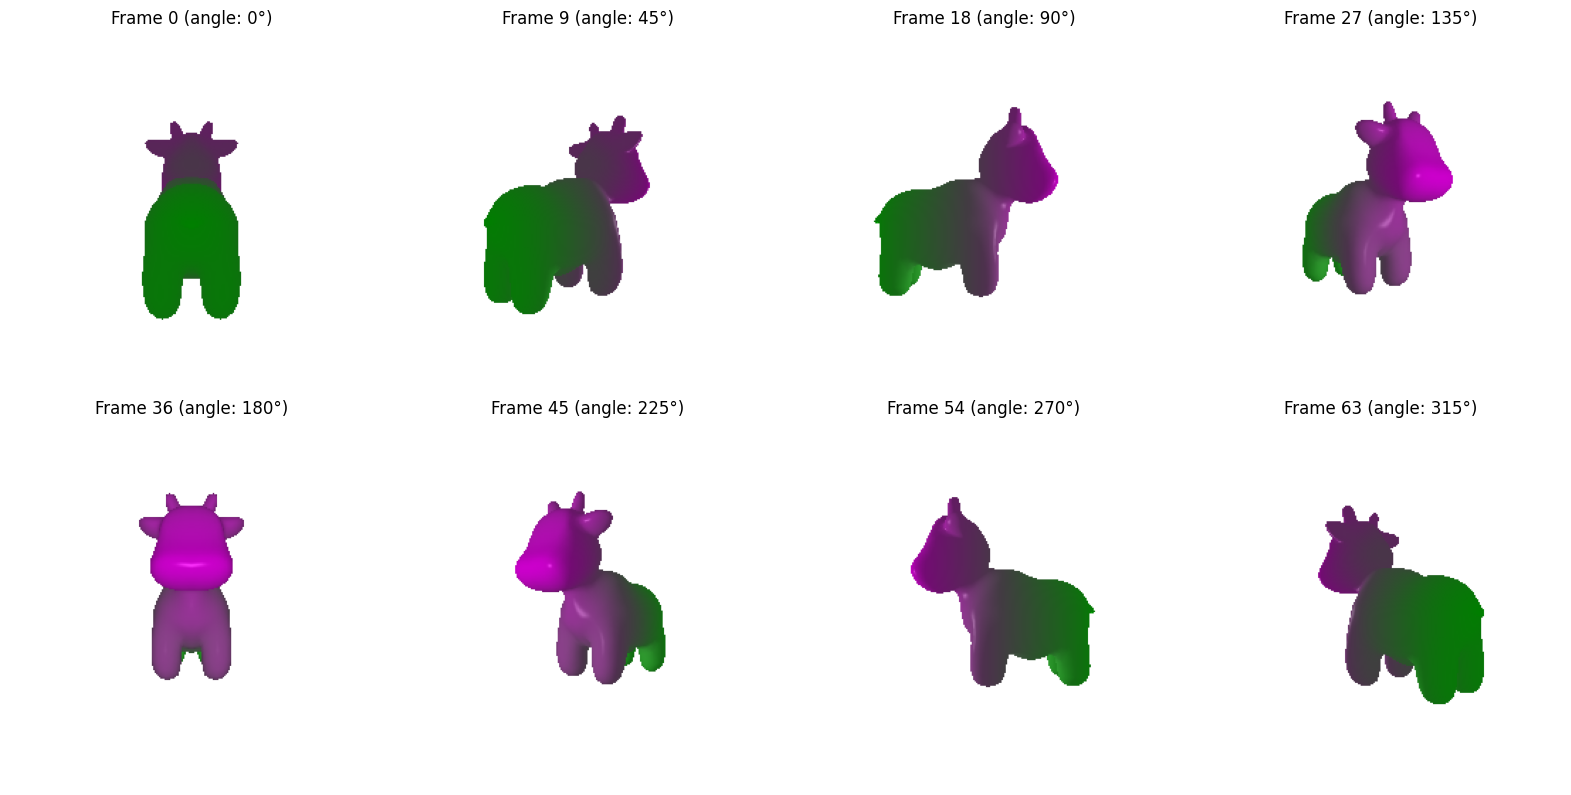

In [40]:
# 3. Re-texturing a mesh
import torch
import pytorch3d
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from starter.utils import get_device, get_mesh_renderer, load_cow_mesh

def create_gradient_texture(vertices, color1, color2):
    """
    Create a gradient texture from front to back of the cow
    Front = smallest z-coordinate (color1)
    Back = largest z-coordinate (color2)
    """
    # Get z-coordinates of all vertices
    z_coords = vertices[:, 2]  # z-coordinate is the 3rd column
    
    # Find min and max z-coordinates
    z_min = torch.min(z_coords)
    z_max = torch.max(z_coords)
    
    print(f"Z-coordinate range: {z_min:.3f} to {z_max:.3f}")
    print(f"Front of cow (z_min): {z_min:.3f}")
    print(f"Back of cow (z_max): {z_max:.3f}")
    
    # Calculate alpha for each vertex (0 = front, 1 = back)
    alpha = (z_coords - z_min) / (z_max - z_min)
    
    # Convert colors to tensors
    color1_tensor = torch.tensor(color1, dtype=torch.float32)
    color2_tensor = torch.tensor(color2, dtype=torch.float32)
    
    # Create gradient texture using linear interpolation
    # For each vertex: color = alpha * color2 + (1 - alpha) * color1
    textures = torch.zeros_like(vertices)
    for i in range(len(vertices)):
        textures[i] = alpha[i] * color2_tensor + (1 - alpha[i]) * color1_tensor
    
    return textures

def render_gradient_cow_360(color1, color2, image_size=256, num_views=72, output_file="outputs/gradient_cow_360.gif"):
    """
    Create a 360-degree gif of the cow with gradient texture
    """
    device = get_device()
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    
    # Load cow mesh
    vertices, faces = load_cow_mesh("data/cow.obj")
    print(f"Loaded cow mesh: {vertices.shape[0]} vertices, {faces.shape[0]} faces")
    
    # Create gradient texture
    textures = create_gradient_texture(vertices, color1, color2)
    
    # Prepare mesh data (PyTorch3D requires batched tensors)
    vertices = vertices.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    faces = faces.unsqueeze(0)  # (N_f, 3) -> (1, N_f, 3)
    textures = textures.unsqueeze(0)  # (N_v, 3) -> (1, N_v, 3)
    
    # Create the mesh
    mesh = pytorch3d.structures.Meshes(
        verts=vertices,
        faces=faces,
        textures=pytorch3d.renderer.TexturesVertex(textures),
    )
    mesh = mesh.to(device)
    
    # Set up lighting
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
    
    # Generate views around the cow
    renders = []
    for angle in tqdm(range(0, 360, 360 // num_views)):
        # Create camera at different azimuth angles
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=3,      # Distance from origin
            elev=0,      # Elevation angle (0 = horizontal)
            azim=angle   # Azimuth angle (rotation around Y-axis)
        )
        
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        # Render
        rend = renderer(mesh, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]
        
        # Convert to uint8 for gif
        rend = (rend * 255).astype(np.uint8)
        renders.append(rend)
    
    # Save as gif
    duration = 1000 // 15  # 67ms per frame for 15 fps
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Gradient cow 360-degree gif saved as {output_file}")
    
    return renders

# Pink to Green
color1 = [1.0, 0.0, 1.0]  # Pink (front)
color2 = [0.0, 1.0, 0.0]  # Green (back)

# Create and render the gradient cow
gradient_renders = render_gradient_cow_360(
    color1=color1,
    color2=color2,
    image_size=256, 
    num_views=72, 
    output_file="outputs/gradient_cow_360.gif"
)

# Display a few frames
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()
for i in range(8):
    frame_idx = i * 9  # Show every 9th frame
    axes[i].imshow(gradient_renders[frame_idx])
    axes[i].set_title(f'Frame {frame_idx} (angle: {frame_idx * 5}°)')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


# 4. Camera Transformations (10 points)

Rendering transformations...
Saved: outputs/transform1_result.jpg
Saved: outputs/transform2_result.jpg
Saved: outputs/transform3_result.jpg
Saved: outputs/transform4_result.jpg


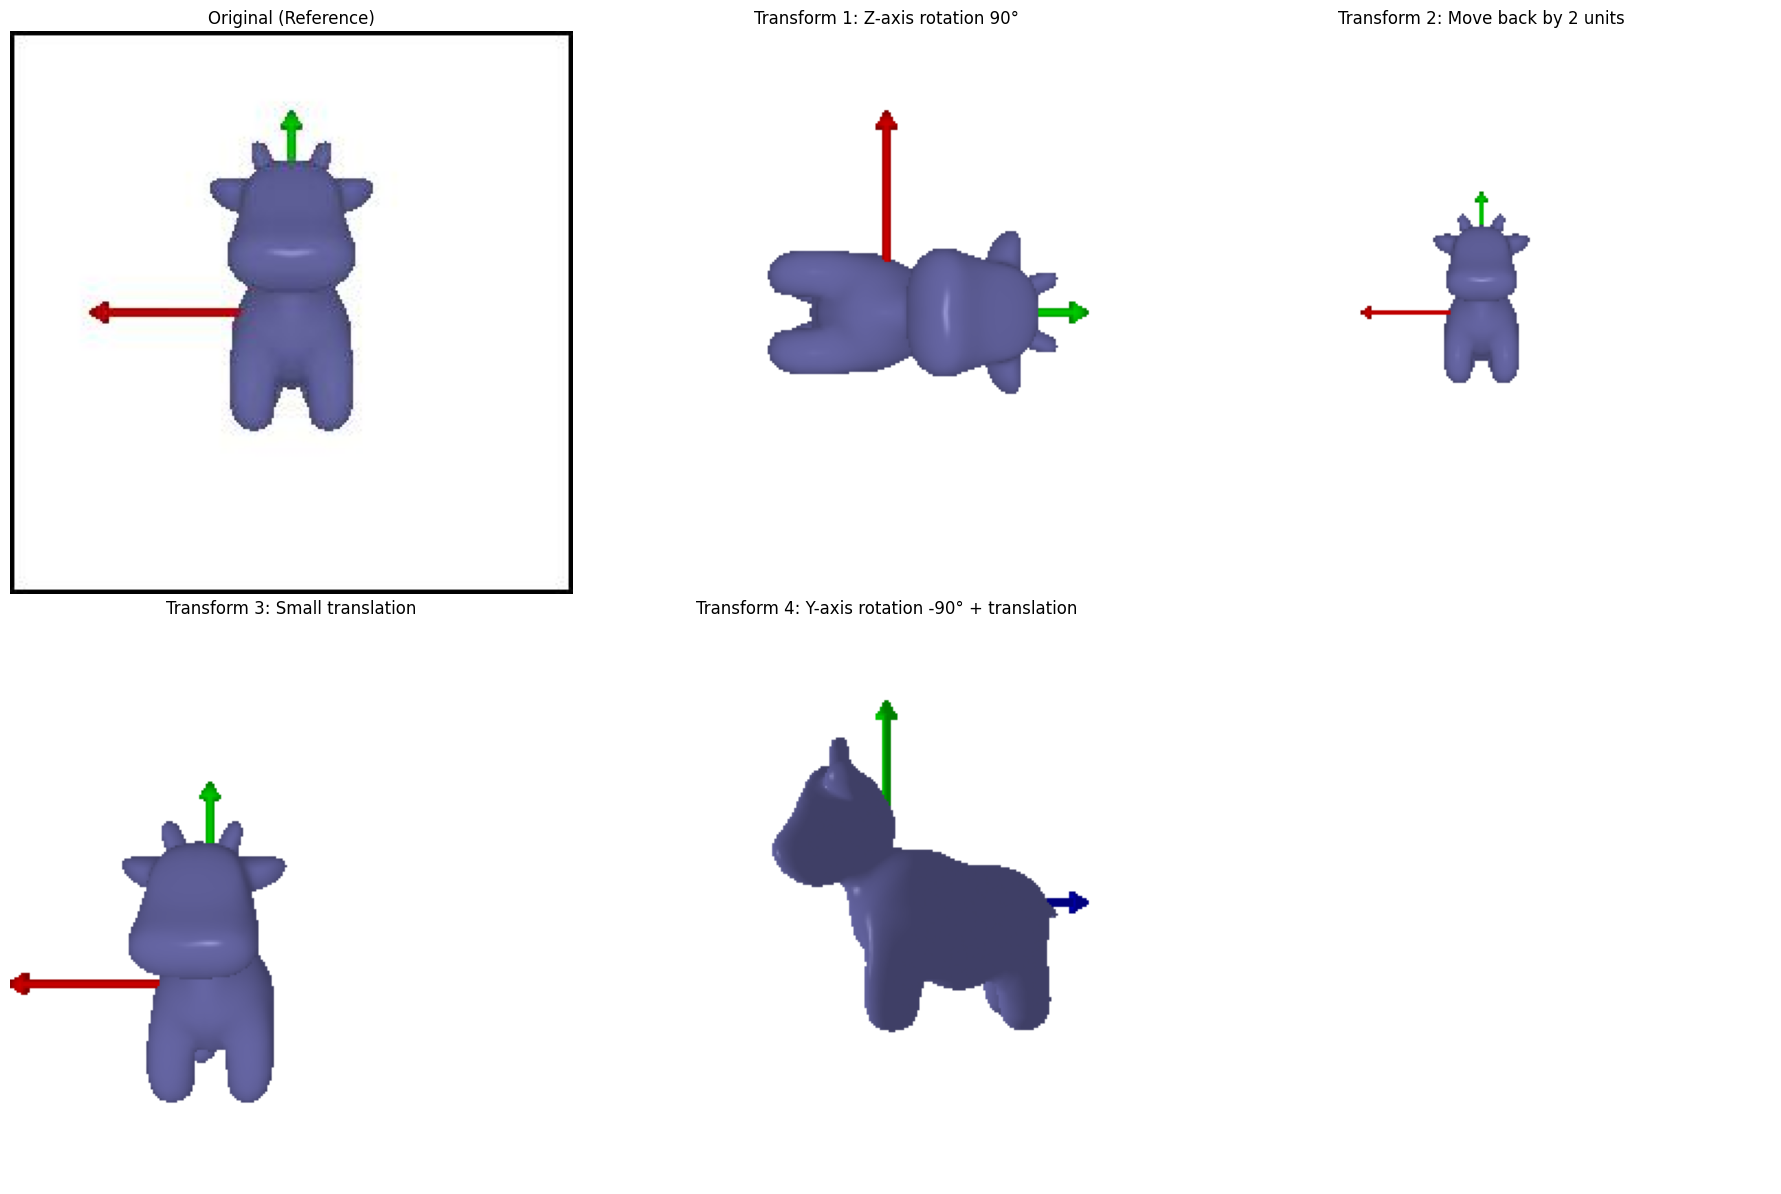

In [43]:
# 4. Camera Transformations
import torch
import pytorch3d
import numpy as np
import matplotlib.pyplot as plt
from starter.utils import get_device, get_mesh_renderer

def render_cow_with_transforms(
    cow_path="data/cow_with_axis.obj",
    image_size=256,
    R_relative=[[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    T_relative=[0, 0, 0],
    device=None,
    save_path="outputs/",
    filename="transform.jpg"
):
    """
    Render cow with camera transformations (corrected version)
    """
    if device is None:
        device = get_device()
    
    # Load the cow mesh with axis
    meshes = pytorch3d.io.load_objs_as_meshes([cow_path]).to(device)
    
    # Convert relative transformations to tensors
    R_relative = torch.tensor(R_relative).float()
    T_relative = torch.tensor(T_relative).float()
    
    # Calculate final camera pose
    R = R_relative @ torch.tensor([[1.0, 0, 0], [0, 1, 0], [0, 0, 1]])
    T = R_relative @ torch.tensor([0.0, 0, 3]) + T_relative
    
    # Important: PyTorch3D uses Point = point@R+t, so we need R.t() to compensate
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(
        R=R.t().unsqueeze(0), T=T.unsqueeze(0), device=device,
    )
    
    # Set up lighting
    lights = pytorch3d.renderer.PointLights(location=[[0, 0.0, -3.0]], device=device)
    
    # Render
    rend = renderer(meshes, cameras=cameras, lights=lights)
    image = rend[0, ..., :3].cpu().numpy()
    
    # Save image
    plt.imsave(save_path + filename, image)
    print(f"Saved: {save_path + filename}")
    
    return image

# Create outputs directory
import os
os.makedirs("outputs", exist_ok=True)

# Transformation 1: Rotation around Z-axis by 90 degrees
angle1 = torch.tensor([0, 0, np.pi/2])  # 90 degrees around Z-axis
R_relative_1 = pytorch3d.transforms.euler_angles_to_matrix(angle1, "XYZ")
T_relative_1 = [0, 0, 0]  # No translation

# Transformation 2: Move camera back by 2 units
R_relative_2 = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # No rotation
T_relative_2 = [0, 0, 2]  # Move camera back

# Transformation 3: Analysis: Small translation to the right and down
R_relative_3 = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])  # No rotation
T_relative_3 = [0.5, -0.5, 0]  # Small translation

# Transformation 4: Rotation around Y-axis by -90 degrees + translation
angle4 = torch.tensor([0, -np.pi/2, 0])  # -90 degrees around Y-axis
R_relative_4 = pytorch3d.transforms.euler_angles_to_matrix(angle4, "XYZ")
T_relative_4 = [3, 0, 3]  # Translation

# Render all transformations
print("Rendering transformations...")

# Render transformation 1
image1 = render_cow_with_transforms(
    R_relative=R_relative_1.tolist(),
    T_relative=T_relative_1,
    filename="transform1_result.jpg"
)

# Render transformation 2
image2 = render_cow_with_transforms(
    R_relative=R_relative_2.tolist(),
    T_relative=T_relative_2,
    filename="transform2_result.jpg"
)

# Render transformation 3
image3 = render_cow_with_transforms(
    R_relative=R_relative_3.tolist(),
    T_relative=T_relative_3,
    filename="transform3_result.jpg"
)

# Render transformation 4
image4 = render_cow_with_transforms(
    R_relative=R_relative_4.tolist(),
    T_relative=T_relative_4,
    filename="transform4_result.jpg"
)

# Display all results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original (reference)
axes[0, 0].imshow(plt.imread("images/transform_none.jpg"))
axes[0, 0].set_title("Original (Reference)")
axes[0, 0].axis('off')

# Transformation 1
axes[0, 1].imshow(image1)
axes[0, 1].set_title("Transform 1: Z-axis rotation 90°")
axes[0, 1].axis('off')

# Transformation 2
axes[0, 2].imshow(image2)
axes[0, 2].set_title("Transform 2: Move back by 2 units")
axes[0, 2].axis('off')

# Transformation 3
axes[1, 0].imshow(image3)
axes[1, 0].set_title("Transform 3: Small translation")
axes[1, 0].axis('off')

# Transformation 4
axes[1, 1].imshow(image4)
axes[1, 1].set_title("Transform 4: Y-axis rotation -90° + translation")
axes[1, 1].axis('off')

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


# 5. Rendering Generic 3D Representations (45 Points)

c:\Users\haejoonl\Anaconda3\envs\learning3d\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


=== 5.1 Rendering Point Clouds from RGB-D Images ===
Generating point clouds from RGB-D data...
Loaded RGB-D data with keys: ['rgb1', 'mask1', 'depth1', 'rgb2', 'mask2', 'depth2', 'cameras1', 'cameras2']
Image 1 shape: torch.Size([800, 800, 3])
Mask 1 shape: torch.Size([800, 800])
Depth 1 shape: torch.Size([800, 800])
Point cloud 1: 125035 points
Image 2 shape: torch.Size([800, 800, 3])
Mask 2 shape: torch.Size([800, 800])
Depth 2 shape: torch.Size([800, 800])
Point cloud 2: 123749 points
Combined point cloud: 248784 points

Creating 360-degree visualizations...
Rendering point cloud 1 (first image)...


100%|██████████| 72/72 [00:01<00:00, 58.58it/s]


Point cloud 360-degree gif saved as outputs/point_cloud_1.gif
Rendering point cloud 2 (second image)...


100%|██████████| 72/72 [00:00<00:00, 75.56it/s]


Point cloud 360-degree gif saved as outputs/point_cloud_2.gif
Rendering combined point cloud...


100%|██████████| 72/72 [00:01<00:00, 46.73it/s]


Point cloud 360-degree gif saved as outputs/point_cloud_combined.gif


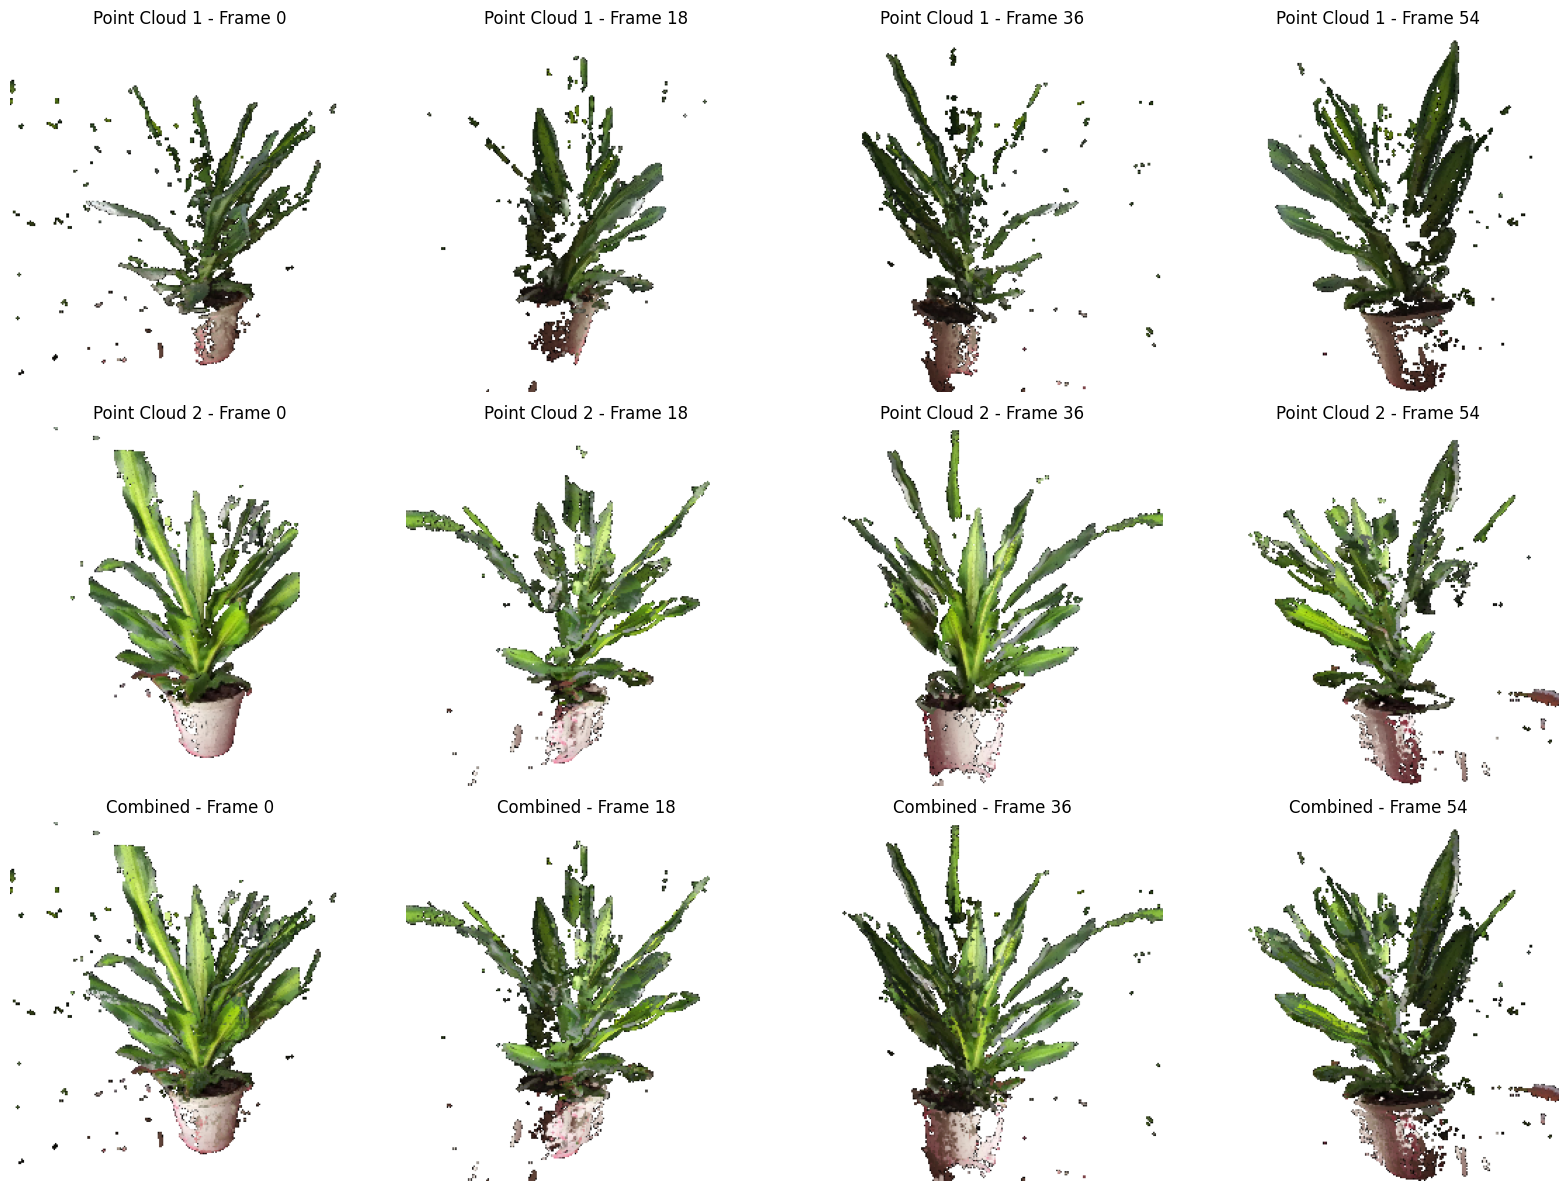

In [ ]:
# 5.1 Rendering Point Clouds from RGB-D Images
import torch
import pytorch3d
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pickle
from starter.utils import get_device, get_points_renderer, unproject_depth_image

def load_rgbd_data(path="data/rgbd_data.pkl"):
    """
    Load RGB-D data from pickle file
    """
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data

def generate_point_clouds(device=None):
    """
    Generate 3 point clouds from RGB-D data:
    1. Point cloud from first image
    2. Point cloud from second image  
    3. Combined point cloud from both images
    """
    if device is None:
        device = get_device()
    
    # Load RGB-D data
    data = load_rgbd_data()
    print("Loaded RGB-D data with keys:", list(data.keys()))
    
    # Process first image
    image1 = torch.Tensor(data["rgb1"])
    mask1 = torch.Tensor(data["mask1"])
    depth1 = torch.Tensor(data["depth1"])
    camera1 = data["cameras1"]
    
    print(f"Image 1 shape: {image1.shape}")
    print(f"Mask 1 shape: {mask1.shape}")
    print(f"Depth 1 shape: {depth1.shape}")
    
    # Unproject depth image to get 3D points and colors
    pts1, rgb1 = unproject_depth_image(image1, mask1, depth1, camera1)
    print(f"Point cloud 1: {pts1.shape[0]} points")
    
    # Process second image
    image2 = torch.Tensor(data["rgb2"])
    mask2 = torch.Tensor(data["mask2"])
    depth2 = torch.Tensor(data["depth2"])
    camera2 = data["cameras2"]
    
    print(f"Image 2 shape: {image2.shape}")
    print(f"Mask 2 shape: {mask2.shape}")
    print(f"Depth 2 shape: {depth2.shape}")
    
    # Unproject depth image to get 3D points and colors
    pts2, rgb2 = unproject_depth_image(image2, mask2, depth2, camera2)
    print(f"Point cloud 2: {pts2.shape[0]} points")
    
    # Create point cloud objects
    verts1 = torch.Tensor(pts1).to(device).unsqueeze(0)
    feat1 = torch.Tensor(rgb1).to(device).unsqueeze(0)
    verts2 = torch.Tensor(pts2).to(device).unsqueeze(0)
    feat2 = torch.Tensor(rgb2).to(device).unsqueeze(0)
    
    # Combined point cloud (union of both)
    verts3 = torch.cat((verts1, verts2), dim=1)
    feat3 = torch.cat((feat1, feat2), dim=1)
    
    print(f"Combined point cloud: {verts3.shape[1]} points")
    
    # Create PyTorch3D point cloud objects
    pcd1 = pytorch3d.structures.Pointclouds(points=verts1, features=feat1)
    pcd2 = pytorch3d.structures.Pointclouds(points=verts2, features=feat2)
    pcd3 = pytorch3d.structures.Pointclouds(points=verts3, features=feat3)
    
    return pcd1, pcd2, pcd3

def visualize_point_cloud_360(
    point_cloud,
    image_size=256,
    background_color=(1, 1, 1),
    output_file="outputs/point_cloud.gif",
    device=None,
    fps=15,
    angle_step=5,
    dist=6,
    elev=0,
    upside_down=True
):
    """
    Create a 360-degree gif of a point cloud
    """
    if device is None:
        device = get_device()
    
    # Get point cloud renderer
    renderer = get_points_renderer(
        image_size=image_size, 
        background_color=background_color,
        radius=0.01  # Point size
    )
    
    if upside_down:
        angle = torch.Tensor([0, 0, np.pi])
    else:
        angle = torch.Tensor([0, 0, 0])
    r = pytorch3d.transforms.euler_angles_to_matrix(angle, "XYZ")
    
    # Generate views around the point cloud
    renders = []
    for azim_angle in tqdm(range(-180, 180, angle_step)):
        # Create camera at different azimuth angles
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=dist,      # Distance from origin
            elev=elev,      # Elevation angle
            azim=azim_angle # Azimuth angle
        )
        
        # Apply additional rotation if needed
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R @ r, T=T, device=device)
        
        # Render
        rend = renderer(point_cloud, cameras=cameras)
        rend = rend.cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)
        
        # Convert to uint8 for gif
        rend = (rend * 255).astype(np.uint8)
        renders.append(rend)
    
    # Save as gif
    duration = 1000 // fps  # Convert fps to duration in ms
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Point cloud 360-degree gif saved as {output_file}")
    
    return renders

# Create outputs directory
import os
os.makedirs("outputs", exist_ok=True)

# Generate the three point clouds
pcd1, pcd2, pcd3 = generate_point_clouds()

print("\nCreating 360-degree visualizations...")

# Visualize point cloud 1 (first image)
print("Rendering point cloud 1 (first image)...")
renders1 = visualize_point_cloud_360(
    pcd1,
    image_size=256,
    output_file="outputs/point_cloud_1.gif",
    dist=6,
    elev=0,
    upside_down=True
)

# Visualize point cloud 2 (second image)
print("Rendering point cloud 2 (second image)...")
renders2 = visualize_point_cloud_360(
    pcd2,
    image_size=256,
    output_file="outputs/point_cloud_2.gif",
    dist=6,
    elev=0,
    upside_down=True
)

# Visualize combined point cloud
print("Rendering combined point cloud...")
renders3 = visualize_point_cloud_360(
    pcd3,
    image_size=256,
    output_file="outputs/point_cloud_combined.gif",
    dist=6,
    elev=0,
    upside_down=True
)

# Display sample frames from each point cloud
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Point cloud 1 frames
for i in range(4):
    frame_idx = i * 18  # Show every 18th frame
    axes[0, i].imshow(renders1[frame_idx])
    axes[0, i].set_title(f'Point Cloud 1 - Frame {frame_idx}')
    axes[0, i].axis('off')

# Point cloud 2 frames
for i in range(4):
    frame_idx = i * 18  # Show every 18th frame
    axes[1, i].imshow(renders2[frame_idx])
    axes[1, i].set_title(f'Point Cloud 2 - Frame {frame_idx}')
    axes[1, i].axis('off')

# Combined point cloud frames
for i in range(4):
    frame_idx = i * 18  # Show every 18th frame
    axes[2, i].imshow(renders3[frame_idx])
    axes[2, i].set_title(f'Combined - Frame {frame_idx}')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


Creating torus point cloud...
Rendering torus 360-degree view...


100%|██████████| 72/72 [00:00<00:00, 88.36it/s] 


Parametric point cloud 360-degree gif saved as outputs/torus_parametric.gif


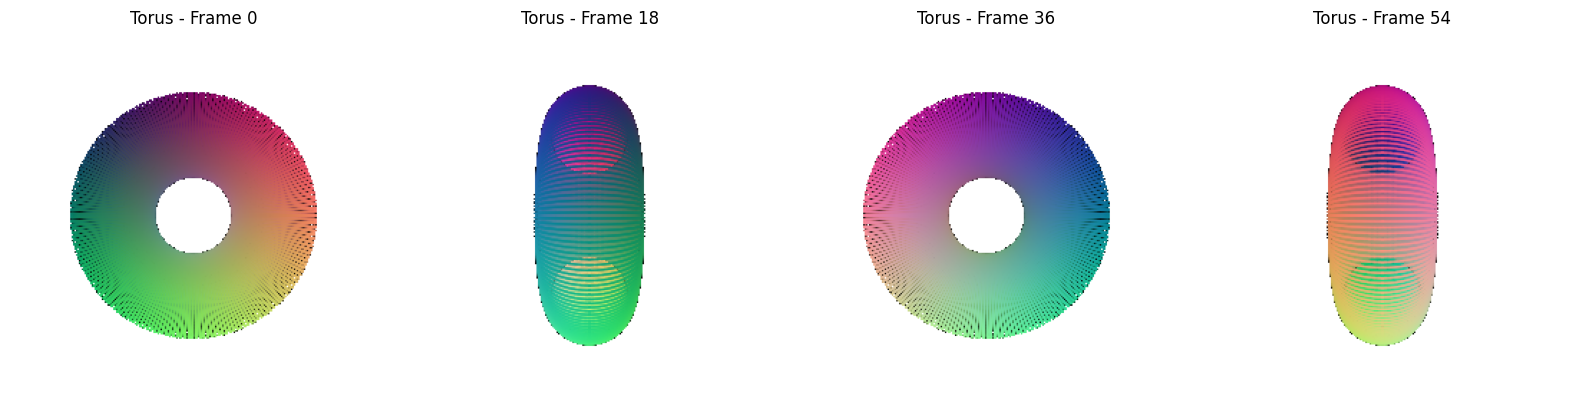

In [44]:
# 5.2 Parametric Functions (Fixed for imageio)
import torch
import pytorch3d
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from starter.utils import get_device, get_points_renderer

def create_torus_point_cloud(num_samples=200, a=1, b=2, device=None):
    """
    Create a torus point cloud using parametric equations (corrected from reference)
    
    Corrected parametric equations for a torus:
    x = a * (cos(theta) + b) * cos(phi)
    y = a * (cos(theta) + b) * sin(phi)  
    z = a * sin(theta)
    
    where:
    - a = scaling factor
    - b = offset for the hole
    - phi, theta are parameters in [0, 2π]
    """
    if device is None:
        device = get_device()
    
    # Create parameter grids (both go from 0 to 2π)
    phi = torch.linspace(0, 2 * np.pi, num_samples)
    theta = torch.linspace(0, 2 * np.pi, num_samples)
    
    # Create meshgrid
    Phi, Theta = torch.meshgrid(phi, theta, indexing="ij")
    
    # Calculate 3D coordinates using corrected torus parametric equations
    x = a * (torch.cos(Theta) + b) * torch.cos(Phi)
    y = a * (torch.cos(Theta) + b) * torch.sin(Phi)
    z = a * torch.sin(Theta)
    
    # Stack coordinates
    points = torch.stack((x.flatten(), y.flatten(), z.flatten()), dim=1)
    
    # Create color based on position (same as reference)
    color = (points - points.min()) / (points.max() - points.min())
    
    # Create point cloud
    torus_point_cloud = pytorch3d.structures.Pointclouds(
        points=[points], features=[color],
    ).to(device)
    
    return torus_point_cloud

def visualize_parametric_point_cloud_360(
    point_cloud,
    image_size=256,
    background_color=(1, 1, 1),
    output_file="outputs/parametric.gif",
    device=None,
    fps=15,
    angle_step=5,
    dist=8,
    elev=0,
    upside_down=True
):
    """
    Create a 360-degree gif of a parametric point cloud (fixed for imageio)
    """
    if device is None:
        device = get_device()
    
    # Get point cloud renderer
    renderer = get_points_renderer(
        image_size=image_size, 
        background_color=background_color,
        radius=0.01  # Point size
    )
    
    if upside_down:
        angle = torch.Tensor([0, 0, np.pi])
    else:
        angle = torch.Tensor([0, 0, 0])
    r = pytorch3d.transforms.euler_angles_to_matrix(angle, "XYZ")
    
    # Generate views around the point cloud
    renders = []
    for azim_angle in tqdm(range(-180, 180, angle_step)):
        # Create camera at different azimuth angles
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=dist,      # Distance from origin
            elev=elev,      # Elevation angle
            azim=azim_angle # Azimuth angle
        )
        
        # Apply additional rotation if needed
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R @ r, T=T, device=device)
        
        # Render
        rend = renderer(point_cloud, cameras=cameras)
        rend = rend.cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)
        
        # Convert to uint8 for gif (same as reference)
        rend = rend * 255
        rend = rend.astype(np.uint8)
        renders.append(rend)
    
    # Save as gif - FIXED: use duration instead of fps
    duration = 1000 // fps  # Convert fps to duration in ms
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Parametric point cloud 360-degree gif saved as {output_file}")
    
    return renders

# Create outputs directory
import os
os.makedirs("outputs", exist_ok=True)

# Create and visualize torus (corrected)
print("Creating torus point cloud...")
torus_pc = create_torus_point_cloud(num_samples=200, a=1, b=2)
print("Rendering torus 360-degree view...")
torus_renders = visualize_parametric_point_cloud_360(
    torus_pc,
    output_file="outputs/torus_parametric.gif",
    dist=8,
    elev=0,
    upside_down=True
)

# Display sample frames
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Torus frames
for i in range(4):
    frame_idx = i * 18  # Show every 18th frame
    axes[i].imshow(torus_renders[frame_idx])
    axes[i].set_title(f'Torus - Frame {frame_idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


Creating torus implicit mesh...
Rendering torus 360-degree view...


100%|██████████| 72/72 [00:00<00:00, 73.34it/s]


Implicit mesh 360-degree gif saved as outputs/torus_implicit.gif


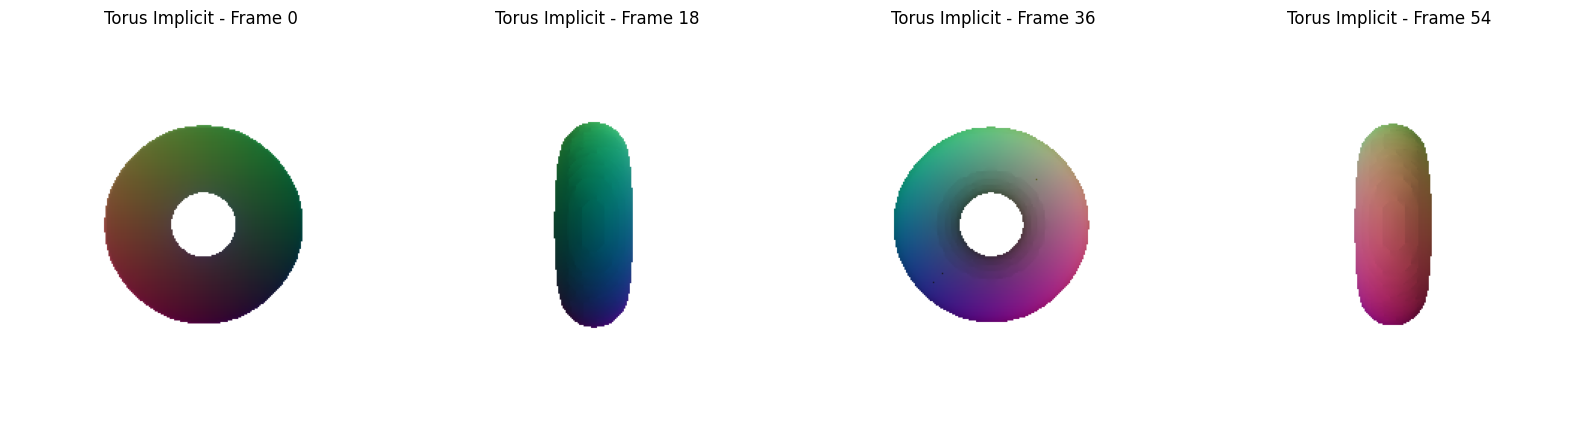

In [45]:
# 5.3 Implicit Surfaces
import torch
import pytorch3d
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import mcubes
from starter.utils import get_device, get_mesh_renderer

def create_torus_implicit_mesh(
    image_size=256, 
    voxel_size=64, 
    device=None,
    a=1,
    b=2,
    dist=10,
    elev=0
):
    """
    Create a torus mesh using implicit function and marching cubes
    """
    if device is None:
        device = get_device()
    
    # Define the 3D space to sample
    min_value = -5
    max_value = 5
    X, Y, Z = torch.meshgrid([torch.linspace(min_value, max_value, voxel_size)] * 3)
    
    # Implicit function for torus: (b - sqrt(x² + y²))² + z² - a² = 0
    # This represents a torus with major radius b and minor radius a
    voxels = (b - np.sqrt(X ** 2 + Y ** 2)) ** 2 + Z ** 2 - a ** 2
    
    # Apply marching cubes to extract the 0-level set
    vertices, faces = mcubes.marching_cubes(mcubes.smooth(voxels), isovalue=0)
    vertices = torch.tensor(vertices).float()
    faces = torch.tensor(faces.astype(int))
    
    # Renormalize vertex coordinates from voxel space to world space
    vertices = (vertices / voxel_size) * (max_value - min_value) + min_value
    
    # Create texture based on vertex positions
    textures = (vertices - vertices.min()) / (vertices.max() - vertices.min())
    textures = pytorch3d.renderer.TexturesVertex(textures.unsqueeze(0))
    
    # Create mesh
    mesh = pytorch3d.structures.Meshes([vertices], [faces], textures=textures).to(device)
    
    return mesh


def render_implicit_mesh_360(
    mesh,
    image_size=256,
    output_file="outputs/implicit_mesh.gif",
    device=None,
    fps=15,
    angle_step=5,
    dist=10,
    elev=0,
    clip=True
):
    """
    Create a 360-degree gif of an implicit mesh
    """
    if device is None:
        device = get_device()
    
    # Set up renderer and lighting
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    lights = pytorch3d.renderer.PointLights(location=[[0, 0.0, -4.0]], device=device)
    
    # Generate views around the mesh
    renders = []
    for azim_angle in tqdm(range(-180, 180, angle_step)):
        # Create camera at different azimuth angles
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=dist,      # Distance from origin
            elev=elev,      # Elevation angle
            azim=azim_angle # Azimuth angle
        )
        
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        # Render
        rend = renderer(mesh, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)
        
        # Clip values to [0, 1] if needed
        if clip:
            rend = rend.clip(0, 1)
        
        # Convert to uint8 for gif
        rend = (rend * 255).astype(np.uint8)
        renders.append(rend)
    
    # Save as gif
    duration = 1000 // fps  # Convert fps to duration in ms
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Implicit mesh 360-degree gif saved as {output_file}")
    
    return renders

# Create outputs directory
import os
os.makedirs("outputs", exist_ok=True)

# 1. Create torus mesh (required)
print("Creating torus implicit mesh...")
torus_mesh = create_torus_implicit_mesh(voxel_size=64, a=1, b=2)
print("Rendering torus 360-degree view...")
torus_renders = render_implicit_mesh_360(
    torus_mesh,
    output_file="outputs/torus_implicit.gif",
    dist=10,
    elev=0
)


# Display sample frames
fig, axes = plt.subplots(1, 4, figsize=(16, 12))

# Torus frames
for i in range(4):
    frame_idx = i * 18  # Show every 18th frame
    axes[i].imshow(torus_renders[frame_idx])
    axes[i].set_title(f'Torus Implicit - Frame {frame_idx}')
    axes[i].axis('off')


plt.tight_layout()
plt.show()

# 6. Do Something Fun (10 points)

Creating torus mesh...
Rendering flying through animation...


100%|██████████| 120/120 [00:03<00:00, 34.26it/s]


Flying through torus animation saved as outputs/flying_through_torus.gif
Creating multiple torus scene...


100%|██████████| 72/72 [00:02<00:00, 35.27it/s]


Multiple torus scene saved as outputs/multiple_torus_scene.gif


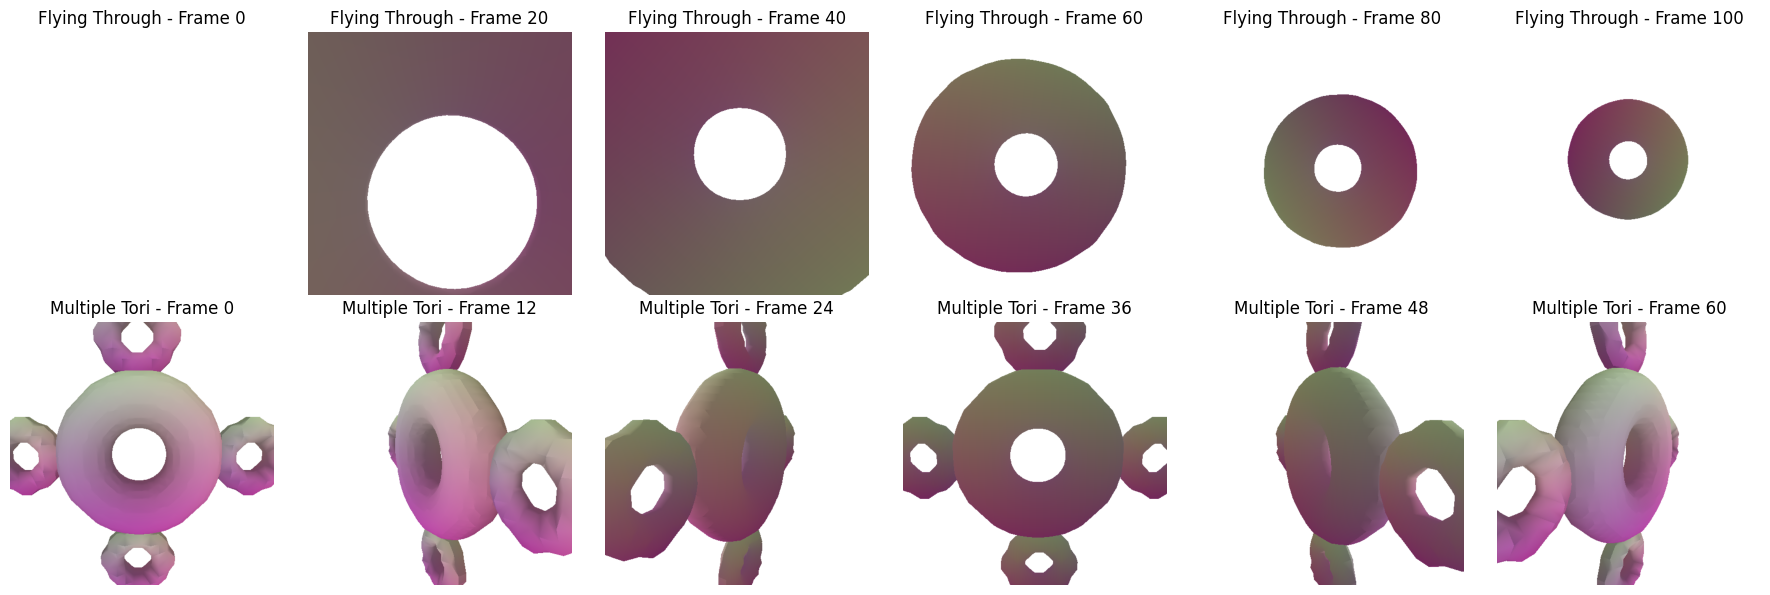

In [35]:
# 6. Do Something Fun - Flying Through Torus (Fixed)
import torch
import pytorch3d
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import mcubes
from starter.utils import get_device, get_mesh_renderer

def create_torus_implicit_mesh(
    image_size=256, 
    voxel_size=64, 
    device=None,
    a=1,
    b=2
):
    """
    Create a torus mesh using implicit function and marching cubes
    """
    if device is None:
        device = get_device()
    
    # Define the 3D space to sample
    min_value = -5
    max_value = 5
    X, Y, Z = torch.meshgrid([torch.linspace(min_value, max_value, voxel_size)] * 3)
    
    # Implicit function for torus: (b - sqrt(x² + y²))² + z² - a² = 0
    voxels = (b - np.sqrt(X ** 2 + Y ** 2)) ** 2 + Z ** 2 - a ** 2
    
    # Apply marching cubes to extract the 0-level set
    vertices, faces = mcubes.marching_cubes(mcubes.smooth(voxels), isovalue=0)
    vertices = torch.tensor(vertices).float()
    faces = torch.tensor(faces.astype(int))
    
    # Renormalize vertex coordinates from voxel space to world space
    vertices = (vertices / voxel_size) * (max_value - min_value) + min_value
    
    # Create colorful texture based on vertex positions
    textures = (vertices - vertices.min()) / (vertices.max() - vertices.min())
    # Make it more vibrant
    textures[:, 0] = 0.8 + 0.2 * textures[:, 0]  # Red channel
    textures[:, 1] = 0.3 + 0.7 * textures[:, 1]  # Green channel
    textures[:, 2] = 0.5 + 0.5 * textures[:, 2]  # Blue channel
    textures = pytorch3d.renderer.TexturesVertex(textures.unsqueeze(0))
    
    # Create mesh
    mesh = pytorch3d.structures.Meshes([vertices], [faces], textures=textures).to(device)
    
    return mesh

def create_flying_through_animation(
    mesh,
    image_size=512,
    output_file="outputs/flying_through_torus.gif",
    device=None,
    fps=30,
    num_frames=120,
    tunnel_radius=1.5,
    tunnel_length=8
):
    """
    Create a flying through animation of the torus
    Camera moves through the torus hole in a spiral pattern
    """
    if device is None:
        device = get_device()
    
    # Set up renderer and lighting
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    lights = pytorch3d.renderer.PointLights(location=[[0, 0.0, -4.0]], device=device)
    
    # Create camera path - spiral through the torus
    t_values = torch.linspace(-tunnel_length/2, tunnel_length/2, num_frames)
    
    renders = []
    for i, t in enumerate(tqdm(t_values)):
        # Create spiral path through the torus
        # The camera moves in a spiral while going through the hole
        
        # Spiral parameters
        spiral_radius = 0.3 * (1 + 0.5 * torch.sin(t * 2))  # Varying radius
        spiral_angle = t * 3  # Multiple rotations
        
        # Camera position (spiral through the torus)
        camera_x = spiral_radius * torch.cos(spiral_angle)
        camera_y = spiral_radius * torch.sin(spiral_angle)
    
        camera_z = t + 4
        
        # Camera target (look ahead in the tunnel)
        target_x = 0.1 * torch.cos(spiral_angle + 0.5)
        target_y = 0.1 * torch.sin(spiral_angle + 0.5)
        target_z = t + 2
        
        # Camera up vector (perpendicular to movement direction)
        up_x = -torch.sin(spiral_angle)
        up_y = torch.cos(spiral_angle)
        up_z = 0
        
        # Create camera transformation
        camera_pos = torch.tensor([camera_x, camera_y, camera_z])
        target_pos = torch.tensor([target_x, target_y, target_z])
        up_vec = torch.tensor([up_x, up_y, up_z])
        
        # Create look-at matrix
        forward = target_pos - camera_pos
        forward = forward / torch.norm(forward)
        
        # Fixed: Use torch.linalg.cross instead of torch.cross
        right = torch.linalg.cross(forward, up_vec)
        right = right / torch.norm(right)
        
        up = torch.linalg.cross(right, forward)
        up = up / torch.norm(up)
        
        # Create rotation matrix
        R = torch.stack([right, up, -forward], dim=0)
        T = camera_pos
        
        # Create camera
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(
            R=R.unsqueeze(0), 
            T=T.unsqueeze(0), 
            fov=90,  # Wide field of view for immersive effect
            device=device
        )
        
        # Render
        rend = renderer(mesh, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)
        
        # Clip values to [0, 1]
        rend = rend.clip(0, 1)
        
        # Convert to uint8 for gif
        rend = (rend * 255).astype(np.uint8)
        renders.append(rend)
    
    # Save as gif
    duration = 1000 // fps  # Convert fps to duration in ms
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Flying through torus animation saved as {output_file}")
    
    return renders

def create_multiple_torus_scene(
    image_size=512,
    output_file="outputs/multiple_torus_scene.gif",
    device=None,
    fps=15,
    num_frames=72
):
    """
    Create a scene with multiple tori at different positions and sizes
    """
    if device is None:
        device = get_device()
    
    # Create multiple tori
    tori_meshes = []
    
    # Main torus (center)
    main_torus = create_torus_implicit_mesh(voxel_size=48, a=1, b=2)
    tori_meshes.append(main_torus)
    
    # Smaller tori around the main one
    for i in range(4):
        angle = i * np.pi / 2
        radius = 4
        
        # Create torus
        torus = create_torus_implicit_mesh(voxel_size=32, a=0.5, b=1)
        
        # Transform position - FIXED: Move to device first
        x_offset = radius * np.cos(angle)
        y_offset = radius * np.sin(angle)
        z_offset = 0
        
        # Apply translation - FIXED: Ensure tensor is on same device
        offset_tensor = torch.tensor([x_offset, y_offset, z_offset], device=device)
        torus.verts_padded()[0] += offset_tensor
        tori_meshes.append(torus)
    
    # Combine all meshes
    all_vertices = []
    all_faces = []
    all_textures = []
    
    face_offset = 0
    for i, mesh in enumerate(tori_meshes):
        vertices = mesh.verts_padded()[0]
        faces = mesh.faces_padded()[0]
        textures = mesh.textures.verts_features_padded()[0]
        
        all_vertices.append(vertices)
        all_faces.append(faces + face_offset)
        all_textures.append(textures)
        
        face_offset += vertices.shape[0]
    
    # Combine into single mesh
    combined_vertices = torch.cat(all_vertices, dim=0)
    combined_faces = torch.cat(all_faces, dim=0)
    combined_textures = torch.cat(all_textures, dim=0)
    
    combined_mesh = pytorch3d.structures.Meshes(
        verts=[combined_vertices],
        faces=[combined_faces],
        textures=pytorch3d.renderer.TexturesVertex(combined_textures.unsqueeze(0))
    ).to(device)
    
    # Set up renderer and lighting
    renderer = get_mesh_renderer(image_size=image_size, device=device)
    lights = pytorch3d.renderer.PointLights(location=[[0, 0.0, -6.0]], device=device)
    
    # Create 360-degree rotation
    renders = []
    for angle in tqdm(range(0, 360, 360 // num_frames)):
        # Create camera at different azimuth angles
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=8,      # Distance from origin
            elev=10,     # Slight elevation
            azim=angle   # Azimuth angle
        )
        
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        # Render
        rend = renderer(combined_mesh, cameras=cameras, lights=lights)
        rend = rend.cpu().numpy()[0, ..., :3]  # (B, H, W, 4) -> (H, W, 3)
        
        # Clip values to [0, 1]
        rend = rend.clip(0, 1)
        
        # Convert to uint8 for gif
        rend = (rend * 255).astype(np.uint8)
        renders.append(rend)
    
    # Save as gif
    duration = 1000 // fps  # Convert fps to duration in ms
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Multiple torus scene saved as {output_file}")
    
    return renders

# Create outputs directory
import os
os.makedirs("outputs", exist_ok=True)


# 1. Create flying through animation
print("Creating torus mesh...")
torus_mesh = create_torus_implicit_mesh(voxel_size=64, a=1, b=2)

print("Rendering flying through animation...")
flying_renders = create_flying_through_animation(
    torus_mesh,
    image_size=512,
    output_file="outputs/flying_through_torus.gif",
    fps=30,
    num_frames=120
)

# 2. Create multiple torus scene
print("Creating multiple torus scene...")
multiple_renders = create_multiple_torus_scene(
    image_size=512,
    output_file="outputs/multiple_torus_scene.gif",
    fps=15,
    num_frames=72
)

# Display sample frames from flying through animation
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

# Flying through frames
for i in range(6):
    frame_idx = i * 20  # Show every 20th frame
    axes[0, i].imshow(flying_renders[frame_idx])
    axes[0, i].set_title(f'Flying Through - Frame {frame_idx}')
    axes[0, i].axis('off')

# Multiple torus frames
for i in range(6):
    frame_idx = i * 12  # Show every 12th frame
    axes[1, i].imshow(multiple_renders[frame_idx])
    axes[1, i].set_title(f'Multiple Tori - Frame {frame_idx}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


# (Extra Credit) 7. Sampling Points on Meshes (10 points)

Loading cow mesh...
Cow mesh: 2930 vertices, 5856 faces

Sampling 10 points from cow mesh...


100%|██████████| 72/72 [00:01<00:00, 58.07it/s]


Mesh vs Point Cloud comparison saved as outputs/cow_sampling_10.gif
✓ Created comparison for 10 samples

Sampling 100 points from cow mesh...


100%|██████████| 72/72 [00:01<00:00, 68.47it/s]


Mesh vs Point Cloud comparison saved as outputs/cow_sampling_100.gif
✓ Created comparison for 100 samples

Sampling 1000 points from cow mesh...


100%|██████████| 72/72 [00:01<00:00, 65.78it/s]


Mesh vs Point Cloud comparison saved as outputs/cow_sampling_1000.gif
✓ Created comparison for 1000 samples

Sampling 10000 points from cow mesh...


100%|██████████| 72/72 [00:01<00:00, 66.06it/s]


Mesh vs Point Cloud comparison saved as outputs/cow_sampling_10000.gif
✓ Created comparison for 10000 samples

Displaying sample frames from 1000-sample comparison...


100%|██████████| 72/72 [00:01<00:00, 67.92it/s]


Mesh vs Point Cloud comparison saved as outputs/sample_display.gif


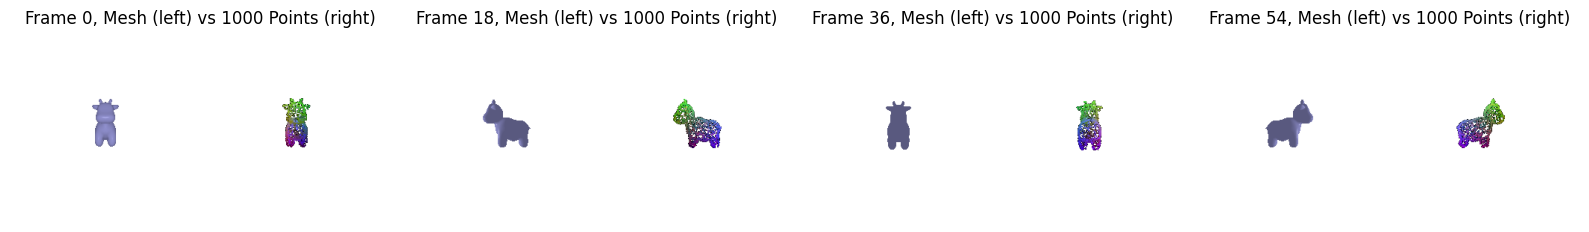

In [48]:
# (Extra Credit) 7. Sampling Points on Meshes
import torch
import pytorch3d
import numpy as np
import imageio
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
from starter.utils import get_device, get_mesh_renderer, get_points_renderer, load_cow_mesh

def calculate_face_areas(vertices, faces):
    """
    Calculate the area of each triangular face in the mesh
    """
    # Get vertices for each face
    face_vertices = vertices[faces]  # Shape: (N_faces, 3, 3)
    
    # Calculate cross product of two edges for each face
    edge1 = face_vertices[:, 1] - face_vertices[:, 0]  # v1 - v0
    edge2 = face_vertices[:, 2] - face_vertices[:, 0]  # v2 - v0
    
    # Cross product gives area of parallelogram, divide by 2 for triangle area
    cross_product = torch.cross(edge1, edge2, dim=1)
    face_areas = torch.norm(cross_product, dim=1) / 2.0
    
    return face_areas

def sample_points_from_mesh(vertices, faces, num_samples):
    """
    Sample points from a triangle mesh using stratified sampling
    
    Procedure:
    1. Sample a face with probability proportional to the area of the face
    2. Sample a random barycentric coordinate uniformly
    3. Compute the corresponding point using barycentric coordinates
    """
    device = vertices.device
    
    # Calculate face areas
    face_areas = calculate_face_areas(vertices, faces)
    
    # Calculate probabilities (proportional to face areas)
    total_area = torch.sum(face_areas)
    face_probabilities = face_areas / total_area
    
    # Sample faces according to their probabilities
    face_indices = torch.multinomial(face_probabilities, num_samples, replacement=True)
    
    # Get vertices for selected faces
    selected_faces = faces[face_indices]  # Shape: (num_samples, 3)
    face_vertices = vertices[selected_faces]  # Shape: (num_samples, 3, 3)
    
    # Sample barycentric coordinates uniformly
    # For a triangle, barycentric coordinates (u, v, w) must satisfy u + v + w = 1
    # We can sample u and v uniformly, then set w = 1 - u - v
    u = torch.rand(num_samples, device=device)
    v = torch.rand(num_samples, device=device)
    
    # Ensure u + v <= 1 (inside triangle)
    # If u + v > 1, we reflect the point to the other half of the square
    mask = u + v > 1
    u[mask] = 1 - u[mask]
    v[mask] = 1 - v[mask]
    
    w = 1 - u - v
    
    # Compute points using barycentric coordinates
    # point = u * v0 + v * v1 + w * v2
    u_expanded = u.unsqueeze(1)  # Shape: (num_samples, 1)
    v_expanded = v.unsqueeze(1)  # Shape: (num_samples, 1)
    w_expanded = w.unsqueeze(1)  # Shape: (num_samples, 1)
    
    sampled_points = (u_expanded * face_vertices[:, 0] + 
                     v_expanded * face_vertices[:, 1] + 
                     w_expanded * face_vertices[:, 2])
    
    return sampled_points

def create_sampled_point_cloud(vertices, faces, num_samples, device=None):
    """
    Create a point cloud by sampling points from a mesh
    """
    if device is None:
        device = get_device()
    
    # Sample points from the mesh
    sampled_points = sample_points_from_mesh(vertices, faces, num_samples)
    
    # Create colors based on position (for visualization)
    colors = (sampled_points - sampled_points.min()) / (sampled_points.max() - sampled_points.min())
    
    # Create point cloud
    point_cloud = pytorch3d.structures.Pointclouds(
        points=[sampled_points],
        features=[colors]
    ).to(device)
    
    return point_cloud

def render_mesh_and_pointcloud_comparison(
    mesh,
    point_cloud,
    image_size=256,
    output_file="outputs/mesh_vs_pointcloud.gif",
    device=None,
    fps=15,
    angle_step=5,
    dist=6,
    elev=0
):
    """
    Render mesh and point cloud side by side in a 360-degree animation
    """
    if device is None:
        device = get_device()
    
    # Set up renderers
    mesh_renderer = get_mesh_renderer(image_size=image_size, device=device)
    point_renderer = get_points_renderer(
        image_size=image_size, 
        background_color=(1, 1, 1),
        radius=0.01
    )
    
    # Set up lighting
    lights = pytorch3d.renderer.PointLights(location=[[0, 0, -3]], device=device)
    
    # Generate views
    renders = []
    for azim_angle in tqdm(range(-180, 180, angle_step)):
        # Create camera
        R, T = pytorch3d.renderer.look_at_view_transform(
            dist=dist, elev=elev, azim=azim_angle
        )
        cameras = pytorch3d.renderer.FoVPerspectiveCameras(R=R, T=T, device=device)
        
        # Render mesh (left side)
        mesh_rend = mesh_renderer(mesh, cameras=cameras, lights=lights)
        mesh_image = mesh_rend.cpu().numpy()[0, ..., :3]
        
        # Render point cloud (right side)
        point_rend = point_renderer(point_cloud, cameras=cameras)
        point_image = point_rend.cpu().numpy()[0, ..., :3]
        
        # Combine images side by side
        combined_image = np.concatenate([mesh_image, point_image], axis=1)
        
        # Convert to uint8
        combined_image = (combined_image * 255).astype(np.uint8)
        renders.append(combined_image)
    
    # Save as gif
    duration = 1000 // fps
    imageio.mimsave(output_file, renders, duration=duration, loop=0)
    print(f"Mesh vs Point Cloud comparison saved as {output_file}")
    
    return renders

# Create outputs directory
import os
os.makedirs("outputs", exist_ok=True)

# Load cow mesh
print("Loading cow mesh...")
vertices, faces = load_cow_mesh("data/cow.obj")
print(f"Cow mesh: {vertices.shape[0]} vertices, {faces.shape[0]} faces")

# Create original mesh for comparison
vertices_batched = vertices.unsqueeze(0)
faces_batched = faces.unsqueeze(0)
textures = torch.ones_like(vertices_batched) * torch.tensor([0.7, 0.7, 1])
original_mesh = pytorch3d.structures.Meshes(
    verts=vertices_batched,
    faces=faces_batched,
    textures=pytorch3d.renderer.TexturesVertex(textures)
).to(get_device())

# Sample different numbers of points
sample_sizes = [10, 100, 1000, 10000]

for num_samples in sample_sizes:
    print(f"\nSampling {num_samples} points from cow mesh...")
    
    # Create sampled point cloud
    sampled_pc = create_sampled_point_cloud(vertices, faces, num_samples)
    
    # Render comparison
    comparison_renders = render_mesh_and_pointcloud_comparison(
        original_mesh,
        sampled_pc,
        output_file=f"outputs/cow_sampling_{num_samples}.gif",
        fps=15,
        angle_step=5
    )
    
    print(f"✓ Created comparison for {num_samples} samples")

# Display sample frames from the 1000-sample comparison
print("\nDisplaying sample frames from 1000-sample comparison...")
sample_renders = render_mesh_and_pointcloud_comparison(
    original_mesh,
    create_sampled_point_cloud(vertices, faces, 1000),
    output_file="outputs/sample_display.gif",
    fps=15,
    angle_step=5
)

fig, axes = plt.subplots(1, 4, figsize=(16, 8))

for i in range(4):
    frame_idx = i * 18  # Show every 18th frame
    axes[i].imshow(sample_renders[frame_idx])
    axes[i].set_title(f'Frame {frame_idx}, Mesh (left) vs 1000 Points (right)')
    axes[i].axis('off')

plt.tight_layout()
plt.show()